In [ ]:
query = """
SELECT *
FROM `stockprediction-434721.stock_data.amzn_prices`
WHERE CAST(Date AS DATE) >= DATE_SUB(CURRENT_DATE(), INTERVAL 5 YEAR)
"""

amzn_df = client.query(query).to_dataframe()

In [ ]:
amzn_df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2019-12-03 00:00:00+00:00,88.00,88.643501,87.361504,88.498001,88.498001,67618000,AMZN
1,2022-09-23 00:00:00+00:00,116.00,116.050003,112.059998,113.779999,113.779999,65126700,AMZN
2,2022-10-26 00:00:00+00:00,116.00,119.349998,114.760002,115.660004,115.660004,68802300,AMZN
3,2024-04-04 00:00:00+00:00,184.00,185.100006,180.000000,180.000000,180.000000,41624300,AMZN
4,2024-07-10 00:00:00+00:00,200.00,200.110001,197.690002,199.789993,199.789993,32883800,AMZN
5,2023-07-06 00:00:00+00:00,128.25,128.729996,127.370003,128.360001,128.360001,40639900,AMZN
6,2020-12-23 00:00:00+00:00,160.25,160.506500,159.208496,159.263504,159.263504,41876000,AMZN
7,2019-12-13 00:00:00+00:00,88.25,88.449501,87.750000,88.046997,88.046997,54914000,AMZN
8,2020-10-09 00:00:00+00:00,160.50,164.449493,159.891495,164.332504,164.332504,98158000,AMZN
9,2021-11-04 00:00:00+00:00,168.50,174.931503,168.250000,173.850006,173.850006,107060000,AMZN


**CLEANING AND PREPROCESSING:**

In [ ]:
# Check for any missing or null values
print(amzn_df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64


In [ ]:
import pandas as pd
# Ensure that Date is in datetime format
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])

In [ ]:
# Drop columns that are not necessary for modeling
# Adjust this based on your needs
amzn_df = amzn_df.drop(columns=['Adj Close'])

In [ ]:
# Sort data by Date in ascending order
amzn_df = amzn_df.sort_values(by='Date', ascending=True)

In [ ]:
# Preview updated dataframes
print(amzn_df.head())

                          Date       Open       High        Low      Close  \
337  2019-09-16 00:00:00+00:00  91.200996  91.284500  90.010002  90.391998   
1226 2019-09-17 00:00:00+00:00  90.353996  91.199501  90.205002  91.127502   
288  2019-09-18 00:00:00+00:00  90.851997  91.102997  89.775002  90.873001   
833  2019-09-19 00:00:00+00:00  91.051003  91.628502  90.894997  91.074997   
1168 2019-09-20 00:00:00+00:00  91.085503  91.531502  89.045998  89.708000   

         Volume Ticker  
337    73510000   AMZN  
1226   39648000   AMZN  
288    50112000   AMZN  
833    40630000   AMZN  
1168  106838000   AMZN  


**FEATURE ENGINEERING:**

1. Create Rolling Features:
Moving Averages (e.g., 7-day, 30-day): These smooth out stock prices and reveal trends.
Volatility (Standard deviation of returns): Indicates stock price variability.
2. Create Lag Features:
Previous day's prices: Prices from a few days ago can help the model see short-term trends.
3. Compute Returns:
Daily returns: Percentage change from one day to the next.

In [ ]:
# Feature Engineering for Amazon

# 1. Moving Averages
amzn_df['7_day_MA'] = amzn_df['Close'].rolling(window=7).mean()
amzn_df['30_day_MA'] = amzn_df['Close'].rolling(window=30).mean()

# 2. Volatility (Standard deviation of daily returns over 7 and 30 days)
amzn_df['7_day_volatility'] = amzn_df['Close'].pct_change().rolling(window=7).std()
amzn_df['30_day_volatility'] = amzn_df['Close'].pct_change().rolling(window=30).std()

# 3. Lag Features (Previous day's price and volume)
amzn_df['Previous_Close'] = amzn_df['Close'].shift(1)
amzn_df['Previous_Volume'] = amzn_df['Volume'].shift(1)

# 4. Daily Returns
amzn_df['Daily_Return'] = amzn_df['Close'].pct_change()

# Preview updated dataframe for Amazon
print(amzn_df.head())

                          Date       Open       High        Low      Close  \
337  2019-09-16 00:00:00+00:00  91.200996  91.284500  90.010002  90.391998   
1226 2019-09-17 00:00:00+00:00  90.353996  91.199501  90.205002  91.127502   
288  2019-09-18 00:00:00+00:00  90.851997  91.102997  89.775002  90.873001   
833  2019-09-19 00:00:00+00:00  91.051003  91.628502  90.894997  91.074997   
1168 2019-09-20 00:00:00+00:00  91.085503  91.531502  89.045998  89.708000   

         Volume Ticker  7_day_MA  30_day_MA  7_day_volatility  \
337    73510000   AMZN       NaN        NaN               NaN   
1226   39648000   AMZN       NaN        NaN               NaN   
288    50112000   AMZN       NaN        NaN               NaN   
833    40630000   AMZN       NaN        NaN               NaN   
1168  106838000   AMZN       NaN        NaN               NaN   

      30_day_volatility  Previous_Close  Previous_Volume  Daily_Return  
337                 NaN             NaN             <NA>           

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Ticker                0
7_day_MA              6
30_day_MA            29
7_day_volatility      7
30_day_volatility    30
Previous_Close        1
Previous_Volume       1
Daily_Return          1
dtype: int64


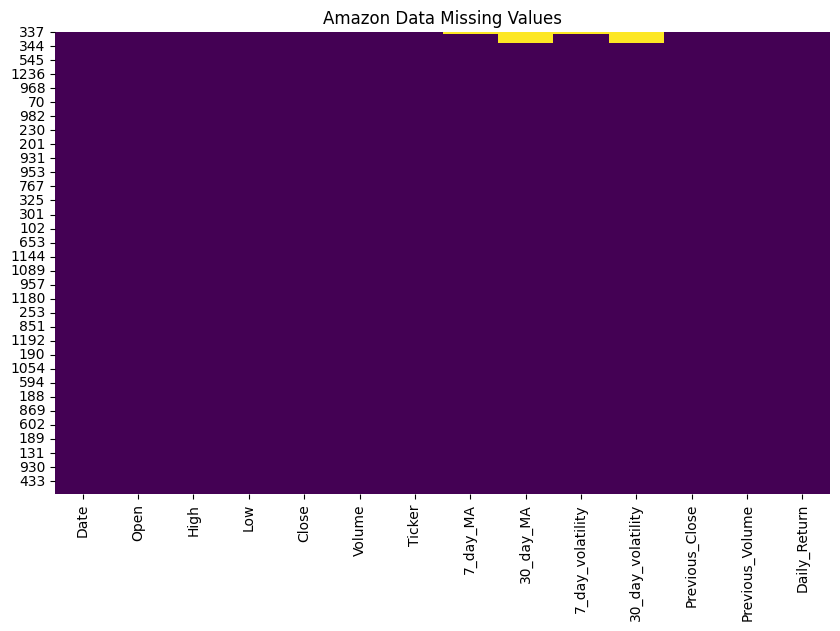

In [ ]:
# Check for missing values in each column for Amazon
print(amzn_df.isna().sum())

# Visualize where NaNs occur in Amazon data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(amzn_df.isna(), cbar=False, cmap="viridis")
plt.title('Amazon Data Missing Values')
plt.show()

Based on the heatmaps and summary, it looks like the missing values are indeed concentrated at the beginning of each dataset, particularly in the moving averages and volatility columns. Since these are rolling calculations, it's normal to see NaN values at the start.

It would be appropriate to drop the rows that contain these NaN values since they appear at the beginning and are not informative for future predictions.

In [ ]:
# Drop rows with NaN values in the Amazon dataframe
amzn_df_cleaned = amzn_df.dropna()

# Preview the cleaned Amazon dataframe
print(amzn_df_cleaned.head())

                          Date       Open       High        Low      Close  \
1039 2019-10-28 00:00:00+00:00  87.403000  88.934998  87.125000  88.853996   
524  2019-10-29 00:00:00+00:00  88.740501  88.849998  87.790497  88.135498   
947  2019-10-30 00:00:00+00:00  88.012001  89.119003  87.956001  88.999496   
143  2019-10-31 00:00:00+00:00  88.799500  89.599998  88.573997  88.833000   
1024 2019-11-01 00:00:00+00:00  89.400497  89.872498  89.260498  89.571999   

        Volume Ticker   7_day_MA  30_day_MA  7_day_volatility  \
1039  74178000   AMZN  88.501856  87.893966          0.012734   
524   45538000   AMZN  88.538998  87.794233          0.011253   
947   48988000   AMZN  88.498498  87.731783          0.009998   
143   55624000   AMZN  88.576570  87.657050          0.008888   
1024  55808000   AMZN  88.785641  87.652516          0.009174   

      30_day_volatility  Previous_Close  Previous_Volume  Daily_Return  
1039           0.011103       88.066498        192528000      0.008

In [ ]:
print(amzn_df_cleaned.shape)

(1221, 14)


Exporting to CSV to update BigQuery table:

In [ ]:
# Export the cleaned and feature-engineered dataframe to a CSV file
amzn_df_cleaned.to_csv('amzn_cleaned_feature_engineered.csv', index=False)
print("Dataframe exported to CSV.")

Dataframe exported to CSV.


In [ ]:
from google.colab import files

# Download the Amazon CSV file to your local machine
files.download('amzn_cleaned_feature_engineered.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**MODEL TRAINING:**

Step 1: Split the Data into Training and Testing Sets

* Training Set: 80% of the data, used to train the model.
* Testing Set: 20% of the data, used to evaluate the model's accuracy.

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X_amzn = amzn_df_cleaned[['7_day_MA', '30_day_MA', '7_day_volatility', '30_day_volatility', 'Previous_Close', 'Previous_Volume', 'Daily_Return']]
y_amzn = amzn_df_cleaned['Close']

# Split the data
X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(X_amzn, y_amzn, test_size=0.2, random_state=42)

# Preview the shapes
print(X_train_amzn.shape, X_test_amzn.shape, y_train_amzn.shape, y_test_amzn.shape)

(976, 7) (245, 7) (976,) (245,)


Step 2: Select Machine Learning Models

* Start with Linear Regression for simplicity and benchmarking.
* Move to Random Forest or XGBoost to capture more complex patterns.
* Optionally, explore ARIMA or LSTM if you want a time-series-specific model.

**LINEAR REGRESSION MODEL:**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model_amzn = LinearRegression()

# Train the model on the training data
model_amzn.fit(X_train_amzn, y_train_amzn)

# Predict on the test data
y_pred_amzn = model_amzn.predict(X_test_amzn)

# Evaluate the model
mse_amzn = mean_squared_error(y_test_amzn, y_pred_amzn)
r2_amzn = r2_score(y_test_amzn, y_pred_amzn)

print("Amazon Linear Regression Performance:")
print(f"Mean Squared Error: {mse_amzn}")
print(f"R-squared: {r2_amzn}")

Amazon Linear Regression Performance:
Mean Squared Error: 0.4787777728733036
R-squared: 0.9994514430344438


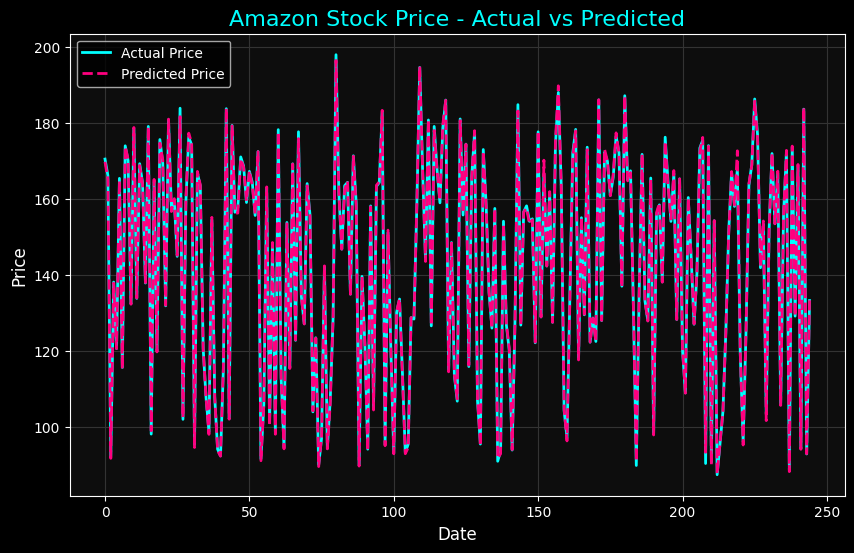

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the cyberpunk theme colors
cyberpunk_blue = '#00FFFF'
cyberpunk_red = '#FF007F'
cyberpunk_background = '#0D0D0D'

# Customize the plot style
plt.style.use('dark_background')

# Plot for Amazon stock
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test_amzn)), y_test_amzn, color=cyberpunk_blue, label='Actual Price', linewidth=2)
plt.plot(np.arange(len(y_pred_amzn)), y_pred_amzn, color=cyberpunk_red, linestyle='--', label='Predicted Price', linewidth=2)
plt.title('Amazon Stock Price - Actual vs Predicted', fontsize=16, color=cyberpunk_blue)
plt.xlabel('Date', fontsize=12, color='white')
plt.ylabel('Price', fontsize=12, color='white')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, color='#333333')
plt.gca().set_facecolor(cyberpunk_background)
plt.show()

**RANDOM FOREST MODEL:**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model for Amazon
rf_amzn = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_amzn.fit(X_train_amzn, y_train_amzn)

# Predict on the test data
y_pred_rf_amzn = rf_amzn.predict(X_test_amzn)

# Evaluate the model
mse_rf_amzn = mean_squared_error(y_test_amzn, y_pred_rf_amzn)
r2_rf_amzn = r2_score(y_test_amzn, y_pred_rf_amzn)

print("Amazon Random Forest Performance:")
print(f"Mean Squared Error: {mse_rf_amzn}")
print(f"R-squared: {r2_rf_amzn}")

Amazon Random Forest Performance:
Mean Squared Error: 3.0215685259436027
R-squared: 0.9965380546973505


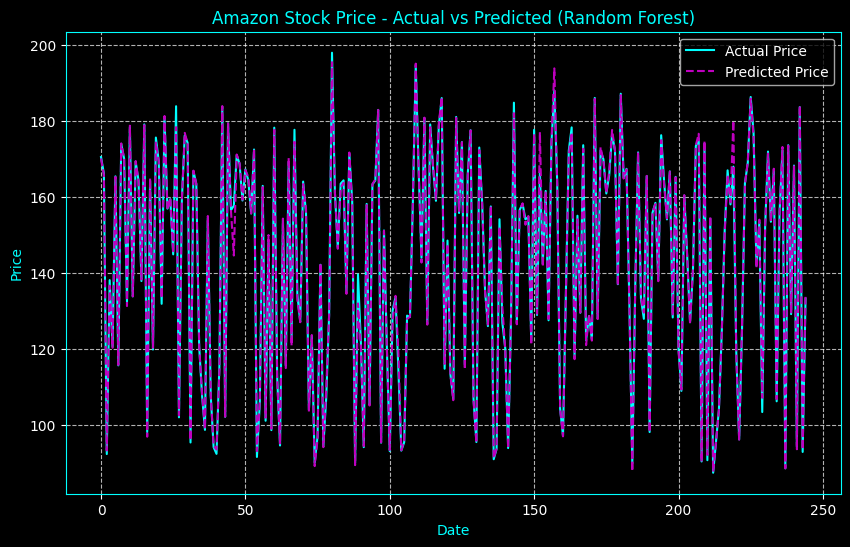

In [ ]:
# Visualization for Random Forest - Amazon
plt.figure(figsize=(10, 6))
plt.plot(y_test_amzn[:250].values, color="cyan", label="Actual Price")
plt.plot(y_pred_rf_amzn[:250], 'm--', label="Predicted Price")
plt.title("Amazon Stock Price - Actual vs Predicted (Random Forest)", color="cyan")
plt.xlabel("Date", color="cyan")
plt.ylabel("Price", color="cyan")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor("black")
plt.gca().spines["bottom"].set_color("cyan")
plt.gca().spines["top"].set_color("cyan")
plt.gca().spines["left"].set_color("cyan")
plt.gca().spines["right"].set_color("cyan")
plt.show()

FEATURE IMPORTANCE ANALYSIS:

explore which features (7-day MA, 30-day volatility, etc.) had the most influence on the stock price predictions.

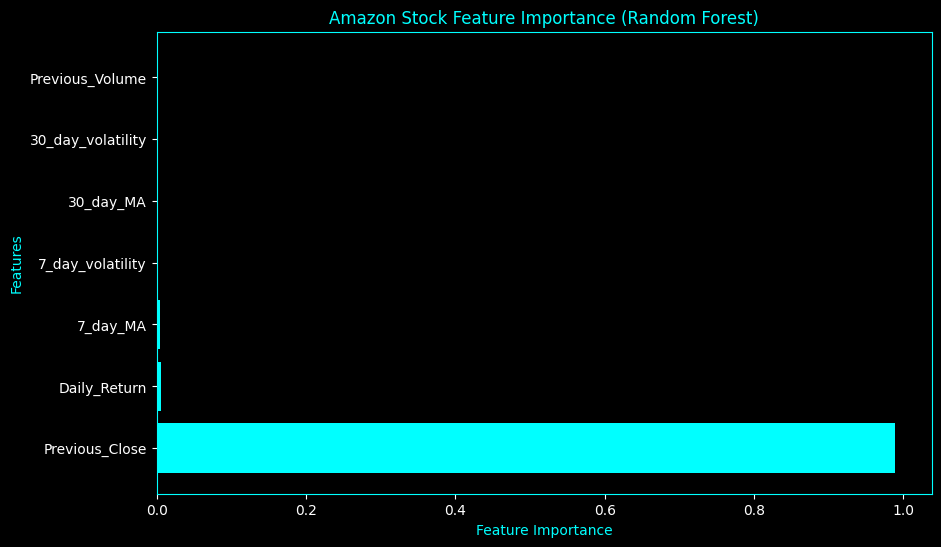

In [ ]:
# Get feature importance from the Random Forest model
importances_amzn = rf_amzn.feature_importances_

# Create a dataframe for the features and their importance
feature_names_amzn = X_train_amzn.columns
importance_df_amzn = pd.DataFrame({
    'Feature': feature_names_amzn,
    'Importance': importances_amzn
})

# Sort the dataframe by importance
importance_df_amzn = importance_df_amzn.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df_amzn['Feature'], importance_df_amzn['Importance'], color='cyan')
plt.xlabel('Feature Importance', color='cyan')
plt.ylabel('Features', color='cyan')
plt.title('Amazon Stock Feature Importance (Random Forest)', color='cyan')
plt.gca().set_facecolor('black')
plt.gca().spines['bottom'].set_color('cyan')
plt.gca().spines['top'].set_color('cyan')
plt.gca().spines['left'].set_color('cyan')
plt.gca().spines['right'].set_color('cyan')
plt.show()

**GRADIENT BOOSTING REGRESSOR:**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Gradient Boosting model for Amazon
gb_amzn = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
gb_amzn.fit(X_train_amzn, y_train_amzn)

# Predict on the test data
y_pred_gb_amzn = gb_amzn.predict(X_test_amzn)

# Evaluate the model
mse_gb_amzn = mean_squared_error(y_test_amzn, y_pred_gb_amzn)
r2_gb_amzn = r2_score(y_test_amzn, y_pred_gb_amzn)

print("Amazon Gradient Boosting Performance:")
print(f"Mean Squared Error: {mse_gb_amzn}")
print(f"R-squared: {r2_gb_amzn}")

Amazon Gradient Boosting Performance:
Mean Squared Error: 1.3739593743462717
R-squared: 0.99842579370244


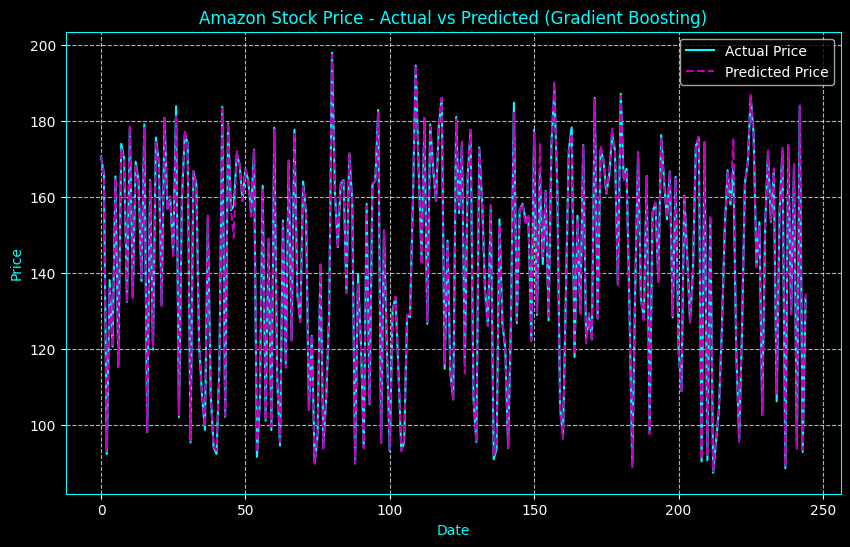

In [ ]:
# Visualization for Gradient Boosting - Amazon
plt.figure(figsize=(10, 6))
plt.plot(y_test_amzn[:250].values, color="cyan", label="Actual Price")
plt.plot(y_pred_gb_amzn[:250], 'm--', label="Predicted Price")
plt.title("Amazon Stock Price - Actual vs Predicted (Gradient Boosting)", color="cyan")
plt.xlabel("Date", color="cyan")
plt.ylabel("Price", color="cyan")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor("black")
plt.gca().spines["bottom"].set_color("cyan")
plt.gca().spines["top"].set_color("cyan")
plt.gca().spines["left"].set_color("cyan")
plt.gca().spines["right"].set_color("cyan")
plt.show()

HYPERPARAMTER TUNING:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
gb_amzn = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_amzn = GridSearchCV(estimator=gb_amzn, param_grid=param_grid,
                                cv=5, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search_amzn.fit(X_train_amzn, y_train_amzn)

# Get the best parameters
best_params_amzn = grid_search_amzn.best_params_
print("Best parameters for Amazon:", best_params_amzn)

# Evaluate the model with the best parameters
best_gb_amzn = grid_search_amzn.best_estimator_
y_pred_amzn = best_gb_amzn.predict(X_test_amzn)
mse_amzn = mean_squared_error(y_test_amzn, y_pred_amzn)
r2_amzn = r2_score(y_test_amzn, y_pred_amzn)

print(f"Amazon Gradient Boosting Performance (Tuned):")
print(f"Mean Squared Error: {mse_amzn}")
print(f"R-squared: {r2_amzn}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for Amazon: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Amazon Gradient Boosting Performance (Tuned):
Mean Squared Error: 1.1142366645223887
R-squared: 0.9987233695500656


the hyperparameter tuning for Amazon has finished successfully, and the best parameters have been found. The performance has improved with a lower mean squared error (MSE) after tuning.


SAVING THE TUNED MODEL:

In [ ]:
import joblib
joblib.dump(best_gb_amzn, 'best_gb_amzn_model.pkl')

['best_gb_amzn_model.pkl']

(FOR FUTURE REFERENCE): LOAD MODEL

In [ ]:
#.    import joblib

# Load the saved Amazon Gradient Boosting model
#.    best_gb_amzn_loaded = joblib.load('best_gb_amzn_model.pkl')

# Predict on new data (assuming `new_data_amzn` is available)
# new_data_amzn should be in the same format as your training data (features)
#.    future_predictions_amzn = best_gb_amzn_loaded.predict(new_data_amzn)

# Print the predictions
#.    print(future_predictions_amzn)

**Long Short-Term Memory (LSTM) Neural Network for stock price prediction:**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Feature scaling
scaler = StandardScaler()
X_train_amzn_scaled = scaler.fit_transform(X_train_amzn)
X_test_amzn_scaled = scaler.transform(X_test_amzn)

# Define the neural network model
model_amzn = Sequential([
    Dense(64, input_dim=X_train_amzn.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model_amzn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_amzn = model_amzn.fit(X_train_amzn_scaled, y_train_amzn, validation_split=0.2, epochs=50, batch_size=32)

# Predict on the test set
y_pred_nn_amzn = model_amzn.predict(X_test_amzn_scaled)

# Evaluate the performance
mse_amzn_nn = mean_squared_error(y_test_amzn, y_pred_nn_amzn)
r2_amzn_nn = r2_score(y_test_amzn, y_pred_nn_amzn)

print(f"Amazon Neural Network Performance:")
print(f"Mean Squared Error: {mse_amzn_nn}")
print(f"R-squared: {r2_amzn_nn}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 20321.0449 - val_loss: 20512.3633
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20410.3848 - val_loss: 20019.0195
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19922.3047 - val_loss: 19088.2773
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18526.8301 - val_loss: 17395.9355
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16592.4102 - val_loss: 14739.0391
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14020.0117 - val_loss: 11208.5176
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10375.9297 - val_loss: 7504.0557
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6743.5605 - val_loss: 4611.0400
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4069.7537 - val_loss: 3084.7883
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2835.8362 - val_loss: 2478.8738
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2332.5850 - val_loss: 2189.9138
Epoch

Notes:
You can adjust the number of neurons, layers, epochs, and batch size to optimize the model.
The StandardScaler ensures that all features are on the same scale, which is important for neural networks.
The models are trained for 50 epochs, but you can adjust the number of epochs based on the performance.


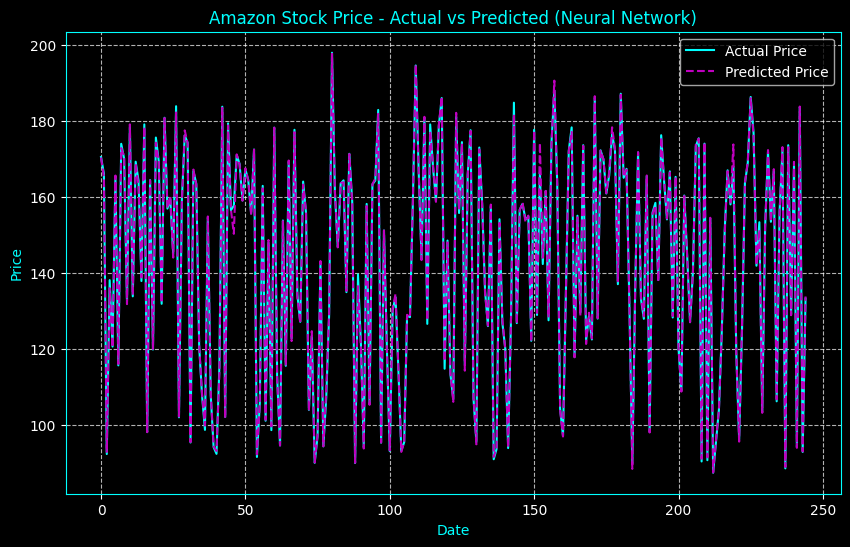

In [ ]:
# Amazon Neural Network Predictions Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test_amzn[:250].values, color="cyan", label="Actual Price")
plt.plot(y_pred_amzn[:250], 'm--', label="Predicted Price")
plt.title("Amazon Stock Price - Actual vs Predicted (Neural Network)", color="cyan")
plt.xlabel("Date", color="cyan")
plt.ylabel("Price", color="cyan")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().set_facecolor("black")
plt.gca().spines["bottom"].set_color("cyan")
plt.gca().spines["top"].set_color("cyan")
plt.gca().spines["left"].set_color("cyan")
plt.gca().spines["right"].set_color("cyan")
plt.show()

In [ ]:
# Save the Neural Network model for Amazon in the native Keras format
model_amzn.save('best_nn_amzn_model_tuned.keras')

In [ ]:
joblib.dump(model_amzn, 'linear_reg_amzn_model.pkl')

['linear_reg_amzn_model.pkl']

In [ ]:
joblib.dump(rf_amzn, 'random_forest_amzn_model.pkl')

['random_forest_amzn_model.pkl']

In [ ]:
joblib.dump(best_gb_amzn, 'gradient_boost_amzn_model.pkl')

['gradient_boost_amzn_model.pkl']

In [ ]:
# Load all Models for Amazon:
from tensorflow.keras.models import load_model

# Load Linear Regression model
linear_reg_amzn_model = joblib.load('linear_reg_amzn_model.pkl')

# Load Random Forest model
random_forest_amzn_model = joblib.load('random_forest_amzn_model.pkl')

# Load Gradient Boosting model
gradient_boost_amzn_model = joblib.load('gradient_boost_amzn_model.pkl')

# Load Neural Network model for Amazon
best_nn_amzn_model = load_model('best_nn_amzn_model_tuned.keras')

In [ ]:
from google.colab import files

# Downloading Amazon models
files.download('linear_reg_amzn_model.pkl')
files.download('random_forest_amzn_model.pkl')
files.download('gradient_boost_amzn_model.pkl')
files.download('best_nn_amzn_model_tuned.keras')

# Download other models as needed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Dashboard:**

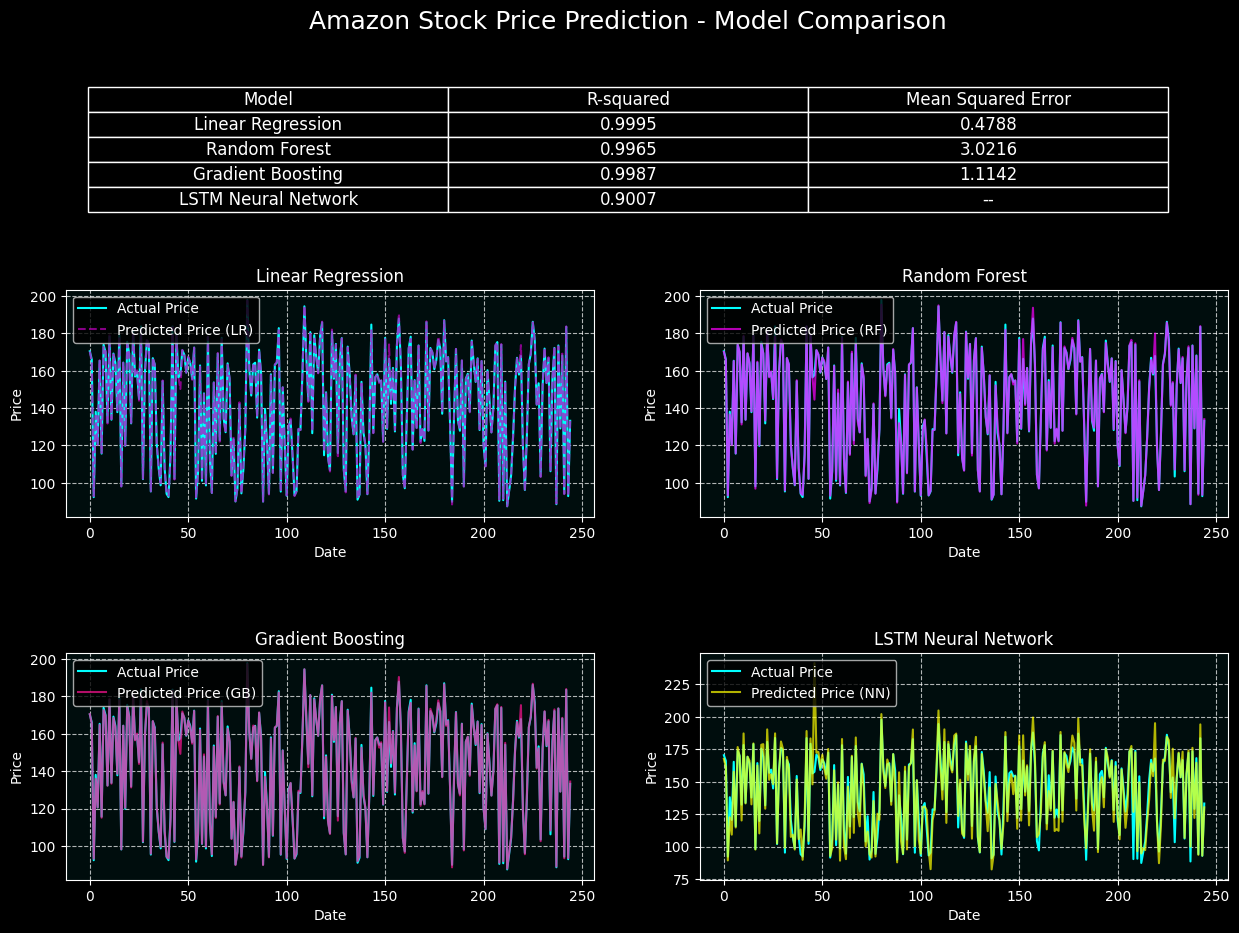

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors
cyberpunk_blue = '#00FFFF'
cyberpunk_pink = '#FF1493'  # This is the pink color for Gradient Boosting
cyberpunk_background = '#000D0D'
random_forest_color = '#FF00FF'  # Magenta for Random Forest
lstm_color = '#FFFF00'  # Yellow for LSTM

# Create subplots: 2 rows, 2 columns
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.6, top=0.70)  # Adjusting space between the charts and shifting top margin for title

# Title for the entire figure
fig.suptitle('Amazon Stock Price Prediction - Model Comparison', fontsize=18, color='white')

# Table with model performance metrics, replacing MSE for Neural Network with '--'
table_data = [
    ["Model", "R-squared", "Mean Squared Error"],
    ["Linear Regression", 0.9995, 0.4788],
    ["Random Forest", 0.9965, 3.0216],
    ["Gradient Boosting", 0.9987, 1.1142],
    ["LSTM Neural Network", 0.9007, "--"]
]

# Add the table without extra space
ax_table = fig.add_axes([0.1, 0.78, 0.8, 0.12])  # Shifting the table slightly lower
ax_table.axis('off')
table = ax_table.table(cellText=table_data, colWidths=[0.3]*3, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Set table background to black and text to white
for key, cell in table.get_celld().items():
    cell.set_edgecolor('white')
    cell.set_text_props(color='white')
    cell.set_facecolor('black')

# Plot 1: Linear Regression
axs[0, 0].plot(np.arange(len(y_test_amzn[:250])), y_test_amzn[:250], color=cyberpunk_blue, label='Actual Price')
axs[0, 0].plot(np.arange(len(y_pred_amzn[:250])), y_pred_amzn[:250], 'm--', label='Predicted Price (LR)', alpha=0.7)
axs[0, 0].set_title('Linear Regression', fontsize=12, color='white')
axs[0, 0].set_xlabel('Date', fontsize=10, color='white')
axs[0, 0].set_ylabel('Price', fontsize=10, color='white')
axs[0, 0].legend(loc='upper left')
axs[0, 0].grid(True, linestyle='--', alpha=0.7)
axs[0, 0].set_facecolor(cyberpunk_background)

# Plot 2: Random Forest (Magenta)
axs[0, 1].plot(np.arange(len(y_test_amzn[:250])), y_test_amzn[:250], color=cyberpunk_blue, label='Actual Price')
axs[0, 1].plot(np.arange(len(y_pred_rf_amzn[:250])), y_pred_rf_amzn[:250], color=random_forest_color, label='Predicted Price (RF)', alpha=0.7)
axs[0, 1].set_title('Random Forest', fontsize=12, color='white')
axs[0, 1].set_xlabel('Date', fontsize=10, color='white')
axs[0, 1].set_ylabel('Price', fontsize=10, color='white')
axs[0, 1].legend(loc='upper left')
axs[0, 1].grid(True, linestyle='--', alpha=0.7)
axs[0, 1].set_facecolor(cyberpunk_background)

# Plot 3: Gradient Boosting (Pink)
axs[1, 0].plot(np.arange(len(y_test_amzn[:250])), y_test_amzn[:250], color=cyberpunk_blue, label='Actual Price')
axs[1, 0].plot(np.arange(len(y_pred_gb_amzn[:250])), y_pred_gb_amzn[:250], color=cyberpunk_pink, label='Predicted Price (GB)', alpha=0.7)  # Pink color
axs[1, 0].set_title('Gradient Boosting', fontsize=12, color='white')
axs[1, 0].set_xlabel('Date', fontsize=10, color='white')
axs[1, 0].set_ylabel('Price', fontsize=10, color='white')
axs[1, 0].legend(loc='upper left')
axs[1, 0].grid(True, linestyle='--', alpha=0.7)
axs[1, 0].set_facecolor(cyberpunk_background)

# Plot 4: LSTM Neural Network (Yellow)
axs[1, 1].plot(np.arange(len(y_test_amzn[:250])), y_test_amzn[:250], color=cyberpunk_blue, label='Actual Price')
axs[1, 1].plot(np.arange(len(y_pred_nn_amzn[:250])), y_pred_nn_amzn[:250], color=lstm_color, label='Predicted Price (NN)', alpha=0.7)
axs[1, 1].set_title('LSTM Neural Network', fontsize=12, color='white')
axs[1, 1].set_xlabel('Date', fontsize=10, color='white')
axs[1, 1].set_ylabel('Price', fontsize=10, color='white')
axs[1, 1].legend(loc='upper left')
axs[1, 1].grid(True, linestyle='--', alpha=0.7)
axs[1, 1].set_facecolor(cyberpunk_background)

# Display the final dashboard
plt.show()
